# Lab 8.2 Timeseries

Derived from CEE599_timeseries.m, November 2015, Jessica Lundquist

Converted to python November 2019, Steven Pestana
***


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.io as sio 
import math as math

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

***
Briefly review sine and cosine functions

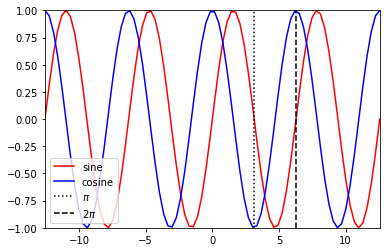

In [2]:
t1 = np.linspace(-4*np.pi,4*np.pi,80)
        
plt.figure()
plt.plot(t1,np.sin(t1),'r-',label='sine')
plt.plot(t1,np.cos(t1),'b-',label='cosine')
plt.plot([np.pi, np.pi],[-1,1],'k:',label='$\pi$')
plt.plot([2*np.pi, 2*np.pi],[-1,1],'k--',label='2$\pi$')
plt.legend(loc='lower left')
plt.xlim((-4*np.pi,4*np.pi))
plt.ylim((-1,1));


Revisit autocorrelation:

Consider the autocorrelation of a sin function at various lags

In [3]:
#Create a sine function evaluated every 0.01 from 0 to 25
# Calculate the autocorrelation at lags from 0.01 (one time-step) to 6 (about a third of the series)
t2 = np.linspace(0,25,25/0.01)
y1 = np.sin(t2)
auto1 = []
for lag in range(1,int(6/0.01)):
    v = np.corrcoef(y1[:-lag],y1[lag:])
    auto1.append(v[0,1])


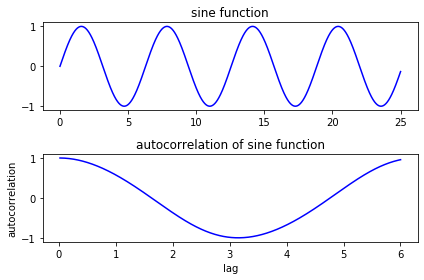

In [4]:
f, ax = plt.subplots(2,1)

ax[0].plot(t2,y1,'b')
ax[0].set_title('sine function')

ax[1].plot(t2[2:601],auto1,'b')
ax[1].set_title('autocorrelation of sine function')
ax[1].set_xlabel('lag')
ax[1].set_ylabel('autocorrelation')
plt.tight_layout()


Look at the autocorrelation again, but this time we're undersampling the sine function

In [5]:
# Step is the interval at which we're sampling.  Try changing it to larger and smaller numbers 
# to test how well we can calculate the true autocorrelation of the sine function
step = 2
t3 = np.linspace(0,25,25/step)
y2 = np.sin(t3)
auto2 = []

for lag in range(1,int(6/step)):
    v = np.corrcoef(y2[:-lag],y2[lag:])
    auto2.append(v[0,1])

N1=len(t2)
N2=len(t3)
print(N1)
print(N2)
print(len(auto2))
NA = len(auto2)

2500
12
2


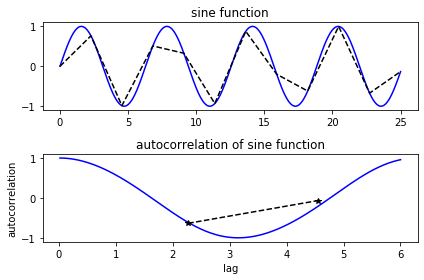

In [6]:
f, ax = plt.subplots(2,1)


ax[0].plot(t2,y1,'b')
ax[0].set_title('sine function')
ax[0].plot(t3,y2,'k--')

ax[1].plot(t2[2:601],auto1,'b')
ax[1].set_title('autocorrelation of sine function')
ax[1].set_xlabel('lag')
ax[1].set_ylabel('autocorrelation')
ax[1].plot(t3[1:NA+1],auto2,'k--')
ax[1].plot(t3[1:NA+1],auto2,'k*')

plt.tight_layout()

#### White vs. Red noise

First, define a function for "red noise":

In [7]:
def rednoise(r,var,N):
    '''
    # r is the lag-1 correlation coefficient
    # var is the variance in the original white noise spectrum
    # N is the length of the series.
    '''
    xwhite = np.sqrt(var)*np.random.normal(size=N) # create some white noise
    xred = xwhite # start off with white
    for ii in range(2,N): # add more red, mix, and repeat
        xred[ii] = r*xred[ii-1] + np.sqrt(1-r**2)*xwhite[ii]
    
    return xred

Create some white noise and some red noise

In [8]:
t = np.linspace(0,2*365,(2*365)*24) # 2 years of timeseries, sampled hourly, measured in days, no leap years

sigmaW = 0.2 #set the variance of the white noise
whitenoise = sigmaW*np.random.normal(size=t.size) # make some white noise

sigmaR = 3 #set the variance of the red noise
r = 0.99 # This is the weighting of the lag-1 regression model (how much does each step
# depend on the step prior) -- try varying it from 0.5 to 0.99
var = 1 #This is the variance of the white noise in the lag-1 regression model -- try varying it as well
xred = sigmaR*rednoise(r,var,t.size) #see rednoise function above

Create imaginary snow-fed streamflow timeseries (or an air temperature timeseries) at hourly timesteps

In [9]:
# Streamflow has 3 components

Qmeanflow = 20*np.ones(t.size); # 10 cms baseflow all the time
Qseasonal = 10*np.sin(2*np.pi*(t-60)/365); # annual repeat cycle, peak in May
Qdaily = np.sin(2*np.pi*(t-6/24)); # diurnal cycle, peak at noon

Qsum = Qmeanflow + Qseasonal + Qdaily + whitenoise + xred # simulate data by summing all these components together

# Try changing the weights on different components above and see both
# how that component changes and how the whole timeseries changes.

Text(0.5, 0, 'days')

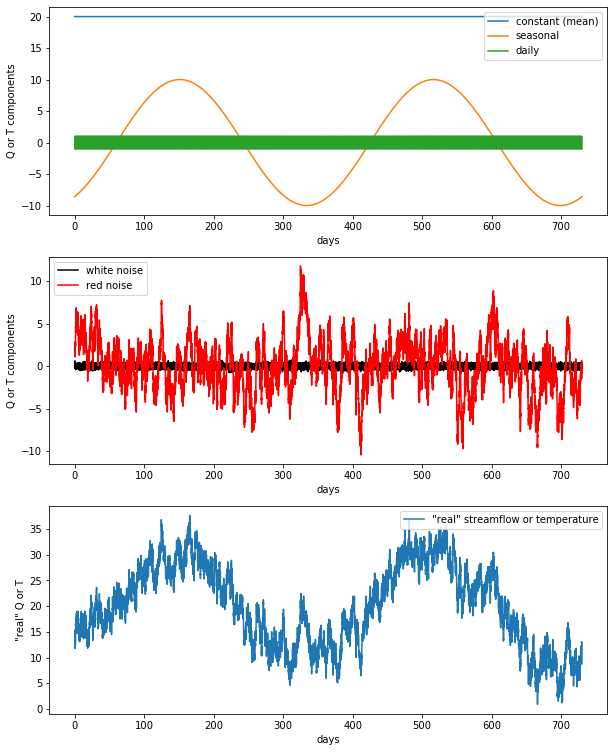

In [10]:
f, ax = plt.subplots(3,1,figsize=(10,13))
ax[0].plot(t,Qmeanflow,'-',label='constant (mean)')
ax[0].plot(t,Qseasonal,'-',label='seasonal')
ax[0].plot(t,Qdaily,'-',label='daily')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Q or T components')
ax[0].set_xlabel('days')

ax[1].plot(t,whitenoise,'k',label='white noise')
ax[1].plot(t,xred,'r',label='red noise')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Q or T components')
ax[1].set_xlabel('days')


ax[2].plot(t,Qsum, label='"real" streamflow or temperature')
ax[2].legend(loc='upper right')
ax[2].set_ylabel('"real" Q or T')
ax[2].set_xlabel('days')

***
We want to use timeseries analysis to decompose the final sum into its component parts (because in the real world, we don't really know what they are). We'll use Fourier transforms, but first we need to understand what on earth the computer is doing with that and spitting back at us!

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875]
[ 0.00000000e+00  7.07106781e-01  1.00000000e+00  7.07106781e-01
  1.22464680e-16 -7.07106781e-01 -1.00000000e+00 -7.07106781e-01]


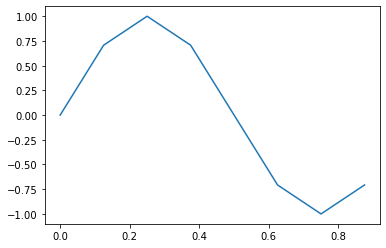

In [11]:
t = np.linspace(0,7/8,8)
f = np.sin(2*math.pi*t)
print(t)
print(f)
plt.figure()
plt.plot(t,f)

Before proceedding, what do you think the coefficients of the Fourier transform should be for this case?

In [12]:
Cns1 = np.fft.fft(f)
print(Cns1)

[ 1.22464680e-16+0.00000000e+00j -3.44509285e-16-4.00000000e+00j
  1.22464680e-16-2.22044605e-16j  9.95799250e-17+0.00000000e+00j
  1.22464680e-16+0.00000000e+00j  9.95799250e-17+0.00000000e+00j
  1.22464680e-16+2.22044605e-16j -3.44509285e-16+4.00000000e+00j]


Note that we got 8 numbers here. This matches our sample size of 8.  The first value is the mean, which for our set should be 0.

In [13]:
print(Cns1[0]) #This is the mean value.  It should be divided by N, the length of the series
# but in this case, it is 0, so we can just look at it to verify that is so.
# Note that rounding error makes it not perfectly 0.
lengthf=len(f)
print(Cns1[0]/lengthf)

(1.2246467991473532e-16+0j)
(1.5308084989341915e-17+0j)


In [14]:
print(Cns1[1]) #the first value corresponds to the coefficients for a frequency of 1 time per cycle
# the real numbers of the cosine coefficients, and the imaginary numbers are the sine coefficients

(-3.4450928483976665e-16-4j)


In [15]:
#to get coefficients of sine and cosine timeseries, we need to divide by N/2 to normalize
# use that with the values in Cns1
a1 = -Cns1[1].imag / (lengthf/2) # first sine coefficient
b1 = Cns1[1].real / (lengthf/2)  # first cosine coefficient
print(a1)
print(b1)

1.0
-8.612732120994166e-17


### Take a moment to make sure you understand the above
Do these values make sense with what you put in?  Try changing the sine and/or cosine amplitudes of the original timeseries.  Also, try changing the sampling frequency (more or less frequently) and see what you get.

### When you feel comfortable with one sinusoid, move on to the one we created with mulitple cycles and with noise.

In [16]:
# Now let's take what we learned and apply it to the timeseries we made up earlier.
N = len(Qsum) # make sure it's even
print(N)

17520


In [17]:
# fft of Qsum
Cns = np.fft.fft(Qsum)

sf = 24 # set our sampling frequency in times per day (see how I defined t, timeseries above)
recoveredmean = Cns[0]/N

In [18]:
# Note that in the prior cases we only sampled a period from 0 to 1
# now we have to define our frequencies

f = np.linspace(0,(N/2),N) * (sf/N)
a = np.zeros_like(Cns)
b = np.zeros_like(Cns)
for n in range(1,int(N/2+1)): # values are offset by one because the first one has the mean (no sine or cosine)
    a[n-1] = -Cns[n].imag / (N/2) # sine coefficients
    b[n-1] = Cns[n].real / (N/2)  # cosine coefficients

Text(0, 0.5, 'values (same as input)')

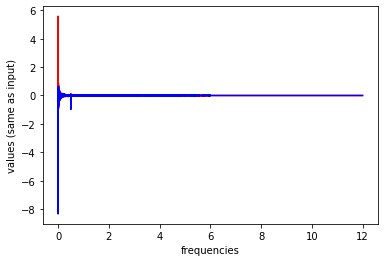

In [19]:
plt.figure()

plt.plot(f,a,'r',label='sine coefficients')
plt.plot(f,b,'b',label='cosine coefficients')

plt.xlabel('frequencies')
plt.ylabel('values (same as input)')

(-1.5, 1.5)

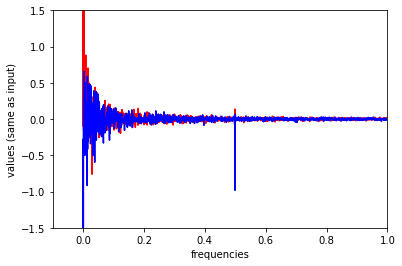

In [20]:
plt.figure()

plt.plot(f,a,'r',label='sine coefficients')
plt.plot(f,b,'b',label='cosine coefficients')

plt.xlabel('frequencies')
plt.ylabel('values (same as input)')
plt.xlim((-0.1,1)) # zoom in here
plt.ylim(-1.5,1.5)

#### Power spectral density
Often we don't want the actual coefficients of the sines and cosines, we just want to know at what frequencies our data are varying

Create a Power Spectral Density plot:

In [21]:
p = np.abs(Cns[:N//2]) # take absolute value to "fold over" power for PSD (but only take the first half, positive frequencies)

# Create freq array (but only take the first half, positive frequencies)
_freq = np.fft.fftfreq(Cns.size, 1/sf)
freq = _freq[:N//2]

This basically calculates the amount of energy (or variance) at different frequencies in the timeseries.

Is there a diurnal cycle, a seasonal cycle, or is it close to red noise you square the complex conjugates?

It's often useful to plot this on log scales as well as regular scales to see what is happening.

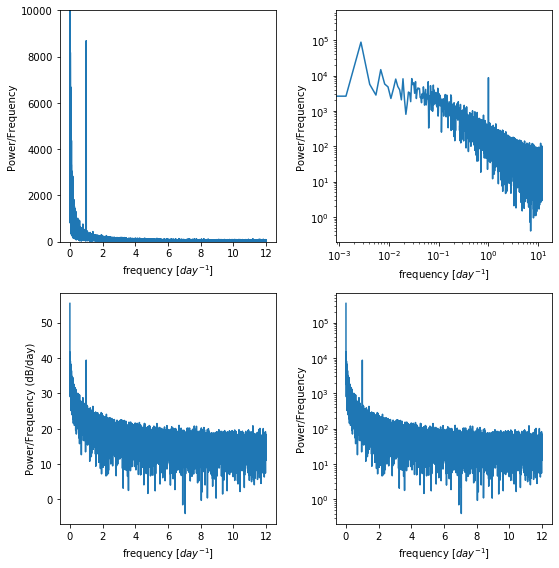

In [22]:
f, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].plot(freq,p)
ax[0,0].set_ylim((0,10000)) # zoom in on the y axis
ax[0,0].set_ylabel('Power/Frequency')
ax[0,0].set_xlabel('frequency [$day^{-1}$]')

ax[0,1].plot(freq,p)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Power/Frequency')
ax[0,1].set_xlabel('frequency [$day^{-1}$]')


ax[1,0].plot(freq,10*np.log10(p))
ax[1,0].set_ylabel('Power/Frequency (dB/day)')
ax[1,0].set_xlabel('frequency [$day^{-1}$]')

ax[1,1].plot(freq,p)
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Power/Frequency')
ax[1,1].set_xlabel('frequency [$day^{-1}$]')

plt.tight_layout()


For example trying to resolve the diurnal cycle, I don't need a whole year

I can divide my timeseries into 4 chunks, get P for each and then average them.

In [23]:
winsize = 4380 # I chose this as 1/4th of a year sampled hourly, but you could change, just be even
nwin = np.floor(N/winsize)
xx = np.reshape(Qsum,(int(winsize),int(nwin)),order='F')

In [24]:
def power_spectral_density(x, sf):
    # perform fft on x
    f = np.fft.fft(x)
    
    # take absolute value to "fold over" power for PSD (but only take the first half, positive frequencies)
    p = np.abs(f[:f.size//2]) 
    
    # Create freq array 
    _freq = np.fft.fftfreq(f.size, sf)
    # (but only take the first half, positive frequencies)
    freq = _freq[:_freq.size//2]
    return freq, p

In [25]:
Pwin = np.zeros((int(winsize/2), int(nwin)))

# Peform fft on each of the subsets of the total timeseries
for m in range(int(nwin)):
    fwin , Pwin[:,m] = power_spectral_density(xx[:,m],1/sf);  
    
p_mean = np.mean(Pwin,axis=1)

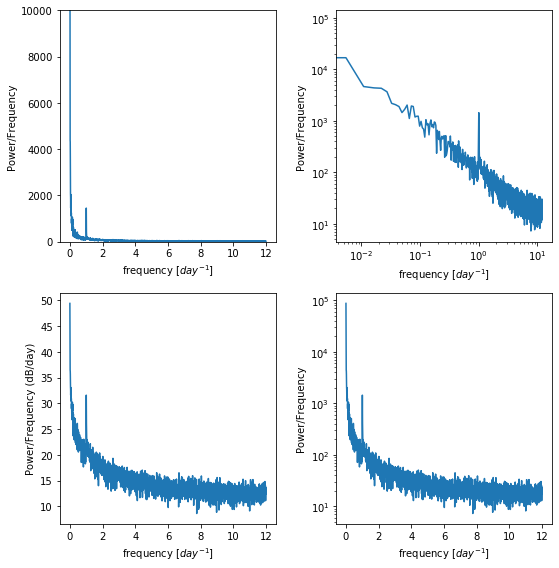

In [26]:
f, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].plot(fwin,p_mean)
ax[0,0].set_ylim((0,10000)) # zoom in on the y axis
ax[0,0].set_ylabel('Power/Frequency')
ax[0,0].set_xlabel('frequency [$day^{-1}$]')

ax[0,1].plot(fwin,p_mean)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Power/Frequency')
ax[0,1].set_xlabel('frequency [$day^{-1}$]')


ax[1,0].plot(fwin,10*np.log10(p_mean))
ax[1,0].set_ylabel('Power/Frequency (dB/day)')
ax[1,0].set_xlabel('frequency [$day^{-1}$]')

ax[1,1].plot(fwin,p_mean)
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Power/Frequency')
ax[1,1].set_xlabel('frequency [$day^{-1}$]')

plt.tight_layout()